<a href="https://colab.research.google.com/github/lovezoyaxu/car-following-model-in-mixtraffic/blob/main/IDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



GA: https://github.com/rmsolgi/geneticalgorithm

In [ ]:
# Installing GA lib for python
!pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15080 sha256=5f57997df646696272a8adec06438790aad50a86038fca67d73333674064d35b
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [ ]:
import numpy as np
from geneticalgorithm import geneticalgorithm as ga
import matplotlib.pyplot as plt
from functools import partial

#导入文件
import scipy.io as sio

load data

In [ ]:
# Download data
!wget https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_train_data.mat --output-document=trainSet.mat
!wget https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_test_data.mat --output-document=testSet.mat

--2024-05-16 10:35:53--  https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_train_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111996 (2.0M) [application/octet-stream]
Saving to: ‘trainSet.mat’

trainSet.mat        100%[===================>]   2.01M  --.-KB/s    in 0.04s   

2024-05-16 10:35:53 (47.6 MB/s) - ‘trainSet.mat’ saved [2111996/2111996]

--2024-05-16 10:35:53--  https://raw.githubusercontent.com/lovezoyaxu/car-following-model-in-mixtraffic/master/L1T100_waymo_test_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

In [ ]:
# load training data
train = sio.loadmat('trainSet.mat')['calibrationData'][:, 0]
test = sio.loadmat(f'testSet.mat')['validationData'][:, 0]

## Simulate a trajectory


In [ ]:
select_segment = 3
lvSpd_obs = test[select_segment][:,-1]
INIT_S = test[select_segment][0,0]
INIT_SVSPD = test[select_segment][0,1]
real_selfSpd = test[select_segment][:,1]
real_spacing = test[select_segment][:,0]

In [ ]:
def IDM(para, spacing, svSpd, relSpd):
    """
    Funciton that takes IDM paramters and car-following states as inputs, and output
    the acceleration for the following vehicle.

    :param para: a vector containing IDM's parameters.
        E.g., para = np.array([32.0489077 ,  0.74084102,  1.18623382,  0.87773747,  1.,2.95210611])
    :param spacing: scaler, gap between two vehicles [m].
    :param svSpd: speed of the following vehicle [m/s].
    :param relSpd: lead vehicle speed - following vehicle speed [m/s].
    :return: acceleration of the following vehicle in next step [m/s^2].
    """
    desiredSpd = para[0] #in m/s
    desiredTimeHdw = para[1] #in seconds
    maxAcc = para[2] # m/s^2
    comfortAcc = para[3] # m/s^2
    beta = para[4]
    jamSpace = para[5] #in meters

    #TODO: put your code here for IDM acceleration calculation.
    desiredSpacing = jamSpace + max(0, desiredTimeHdw*svSpd-svSpd*relSpd/(2*np.sqrt(maxAcc*comfortAcc)))
    acc = maxAcc*(1-(svSpd/desiredSpd)**beta-(desiredSpacing/spacing)**2)

    return acc

def simulate_car_fol(model_fun, lvSpd, init_s, init_svSpd, para):
    """
    Simulate a car following event based on a car-following model.

    :param model_fun:
    """
    T = 0.1 # data sampling interval

    svSpd_sim = []
    spacing_sim = []
    spacing, svSpd, relSpd = init_s, init_svSpd, lvSpd[0] - init_svSpd

    svSpd_sim.append(svSpd)
    spacing_sim.append(spacing)

    for i in range(1, len(lvSpd)):
        # calcualate next_step acceleration using IDM model
        acc = model_fun(para, spacing, svSpd, relSpd)

        # state update based on Newton's motion law
        svSpd_ = max(0.001, svSpd + acc*T) # next step svSpd
        relSpd_ = lvSpd[i] - svSpd_
        spacing_ = spacing + T*(relSpd_ + relSpd)/2

        # update state variables
        svSpd = svSpd_
        relSpd = relSpd_
        spacing = spacing_

        # store simulation results
        svSpd_sim.append(svSpd)
        spacing_sim.append(spacing)

    return np.asarray(svSpd_sim), np.asarray(spacing_sim)

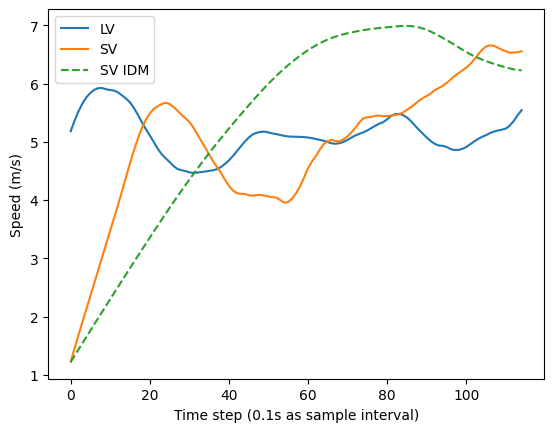

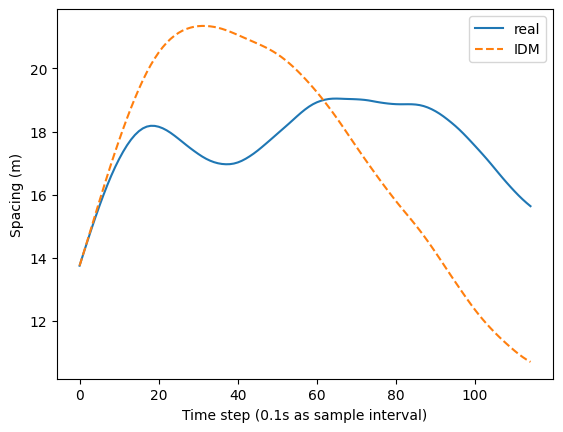

In [ ]:
# We use this set of IDM paramters to simualte
para = np.array([32.0489077,  0.74084102, 1.18623382,  0.87773747,  1., 2.95210611])
svSpd_sim, spacing_sim = simulate_car_fol(IDM, lvSpd_obs, INIT_S, INIT_SVSPD, para)

# This is the trajectory used for model calibration: evaluating the errors.
IDM_SVSPD_GT, IDM_SPACING_GT = svSpd_sim, spacing_sim

plt.plot(lvSpd_obs, label = 'LV')
plt.plot(real_selfSpd, label = 'SV')
plt.plot(svSpd_sim, '--', label = 'SV IDM')
plt.legend()
plt.xlabel('Time step (0.1s as sample interval)')
plt.ylabel('Speed (m/s)')
plt.show()

plt.figure()
plt.plot(real_spacing, label = 'real')
plt.plot(spacing_sim, '--', label = 'IDM')
plt.legend()
plt.xlabel('Time step (0.1s as sample interval)')
plt.ylabel('Spacing (m)')
plt.show()


## Model calibration based on the simulated trajectory

 The best solution found:
 [21.18002438  1.22744793  1.07663839  1.2986986   3.81876269  2.1423282 ]

 Objective function:
 0.006064980026769002


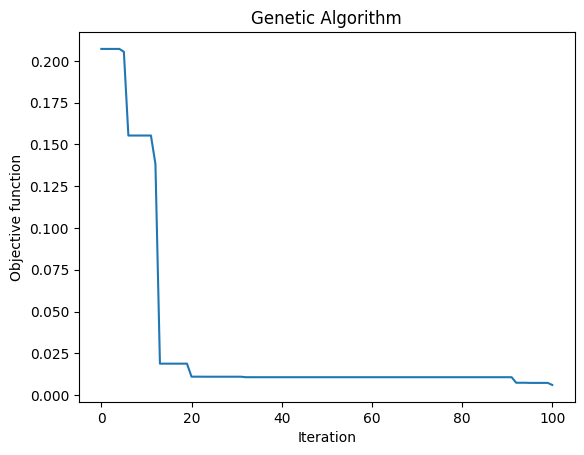

In [ ]:
simulate_partial_func = partial(simulate_car_fol, IDM, lvSpd_obs, INIT_S, INIT_SVSPD)

def evaluate(simulate_partial_func, svSpd_gt, spacing_gt, para):
    svSpd_sim, spacing_sim = simulate_partial_func(para)
    error = np.mean((svSpd_sim - svSpd_gt)**2) + np.mean((spacing_sim - spacing_gt)**2)
    return error

fitness_func = partial(evaluate, simulate_partial_func, IDM_SVSPD_GT, IDM_SPACING_GT)

# TODO: adjust these paramters to have lower errors.
algorithm_param = {'max_num_iteration': 100,\
                   'population_size':100,\
                   'mutation_probability':0.2,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.3,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':100}

varbound=np.array(
       [[ 1.        , 41.66666667],
       [ 0.1       ,  5.        ],
       [ 0.1       ,  5.        ],
       [ 0.1       ,  5.        ],
       [ 1.        , 10.        ],
       [ 0.1       , 10.        ]]
       )

model=ga(function=fitness_func,dimension=len(varbound),variable_type='real',
         variable_boundaries=varbound,
         algorithm_parameters=algorithm_param
         )

model.run()

## Comparison

In [ ]:
print(f'Original parameters: {para}')
print(f'Estimated parameters: {model.best_variable}')

Original parameters: [32.0489077   0.74084102  1.18623382  0.87773747  1.          2.95210611]
Estimated parameters: [21.18002438  1.22744793  1.07663839  1.2986986   3.81876269  2.1423282 ]


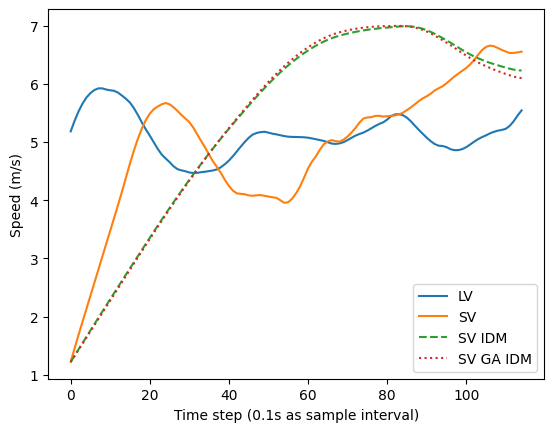

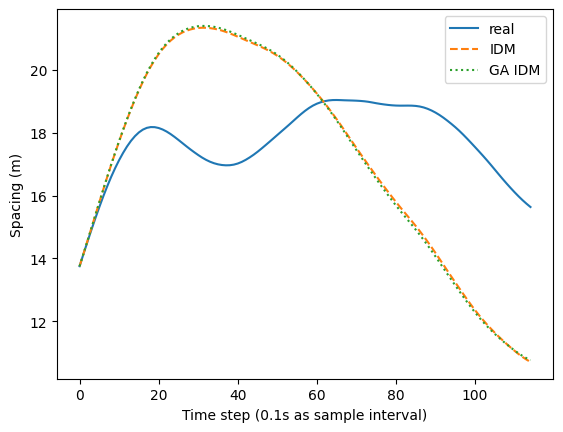

In [ ]:
svSpd_GA, spacing_GA = simulate_car_fol(IDM, lvSpd_obs, INIT_S, INIT_SVSPD, model.best_variable)

plt.plot(lvSpd_obs, label = 'LV')
plt.plot(real_selfSpd, label = 'SV')
plt.plot(svSpd_sim, '--', label = 'SV IDM')
plt.plot(svSpd_GA, ':', label = 'SV GA IDM')
plt.legend()
plt.xlabel('Time step (0.1s as sample interval)')
plt.ylabel('Speed (m/s)')
plt.show()

plt.figure()
plt.plot(real_spacing, label = 'real')
plt.plot(spacing_sim, '--', label = 'IDM')
plt.plot(spacing_GA, ':', label = 'GA IDM')
plt.legend()
plt.xlabel('Time step (0.1s as sample interval)')
plt.ylabel('Spacing (m)')
plt.show()

#print(spacing_GA)
#print(svSpd_GA)